![alt text](https://i.imgur.com/ipYa6Q8.png)

## PyTorch on TPUs: Fast Neural Style Transfer

This notebook lets you run a pre-trained fast neural style transfer network implemented in PyTorch on a Cloud TPU. You can combine pictures and styles to create fun new images. 

You can learn more about fast neural style transfer from its implementation [here](https://github.com/pytorch/examples/tree/master/fast_neural_style) or the original paper, available [here](https://arxiv.org/abs/1603.08155).

This notebook loads PyTorch and stores the network on your Google drive. After this automated setup process (it takes a couple minutes) you can put in a link to an image and see your style applied in seconds!

You can find more examples of running PyTorch on TPUs [here](https://github.com/pytorch/xla/tree/master/contrib/colab), including tutorials on how to run PyTorch on hundreds of TPUs with Google Cloud Platform. 

### Installs PyTorch & Loads the Networks
(This may take a couple minutes.)

Fast neural style transfer networks use the same architecture but different weights to encode their styles. This notebook creates four fast neural style transfer networks: "rain princess," "candy," "mosaic," and "udnie." You can apply these styles below.

In [1]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 149.9 MB 30 kB/s 
     |████████████████████████████████| 57 kB 2.6 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.284 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


### Only run the below commented cell if you would like a nightly release

In [3]:
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [4]:
from google.colab.patches import cv2_imshow
import cv2
import sys

# Configures repo in local colab fs
REPO_DIR = '/demo'
%mkdir -p "$REPO_DIR"
%cd "$REPO_DIR" 
%rm -rf examples
!git clone https://github.com/pytorch/examples.git 
%cd "$REPO_DIR/examples/fast_neural_style"

# Download pretrained weights for styles
!python download_saved_models.py
%cd "$REPO_DIR/examples/fast_neural_style/neural_style"


## Creates pre-trained style networks
import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import utils
from transformer_net import TransformerNet
from vgg import Vgg16

# Acquires the XLA device (a TPU core)
device = xm.xla_device()

# Loads pre-trained weights
rain_princess_path = '../saved_models/rain_princess.pth'
candy_path = '../saved_models/candy.pth'
mosaic_path = '../saved_models/mosaic.pth'
udnie_path = '../saved_models/udnie.pth'

# Loads the pre-trained weights into the fast neural style transfer
# network architecture and puts the network on the Cloud TPU core.
def load_style(path):
  with torch.no_grad():
    model = TransformerNet()
    state_dict = torch.load(path)
    # filters deprecated running_* keys from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    model.load_state_dict(state_dict)
    return model.to(device)

# Creates each fast neural style transfer network
rain_princess = load_style(rain_princess_path)
candy = load_style(candy_path)
mosaic = load_style(mosaic_path)
udnie = load_style(udnie_path)

/demo
Cloning into 'examples'...
remote: Enumerating objects: 2876, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 2876 (delta 3), reused 6 (delta 1), pack-reused 2863
Receiving objects: 100% (2876/2876), 39.18 MiB | 18.16 MiB/s, done.
Resolving deltas: 100% (1442/1442), done.
/demo/examples/fast_neural_style
100% 23.9M/23.9M [00:00<00:00, 61.0MB/s]
/demo/examples/fast_neural_style/neural_style


## Try it out!

The next cell loads and display an image from a URL. This image is styled by the following cell. You can re-run these two cells as often as you like to style multiple images.

Start by copying and pasting an image URL here (or use the default corgi).

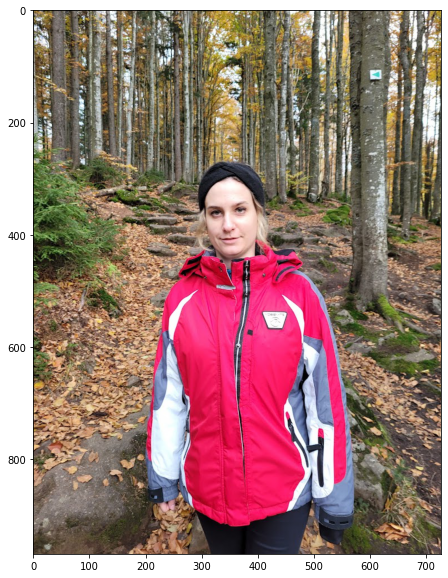

In [32]:
import matplotlib.pyplot as plt
content_image = '20211025_164805.jpg'

img = cv2.imread(content_image, cv2.IMREAD_UNCHANGED)

content_image = utils.load_image(content_image, scale=None)
content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)

content_image_path = '20211025_164805.jpg'
image = plt.imread(content_image_path)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(image)

To style your image simply uncomment the style you wish to apply below and run the cell!

In [46]:
 output1 = rain_princess(content_image)

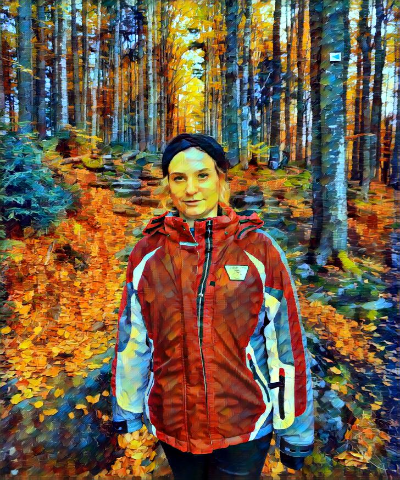

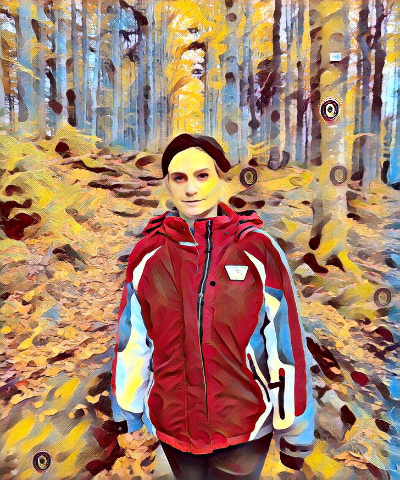

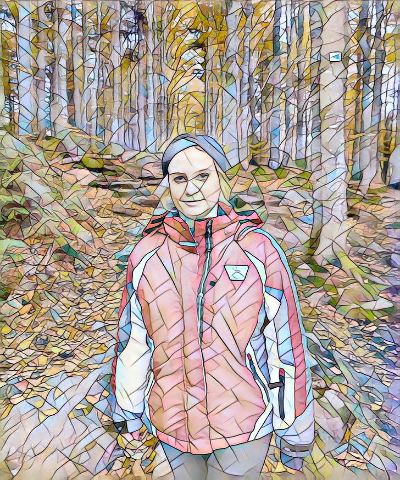

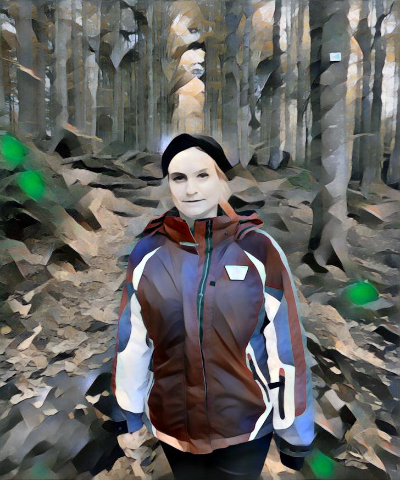

In [55]:
with torch.no_grad():
  output1 = rain_princess(content_image)
  output2 = candy(content_image)
  output3 = mosaic(content_image)
  output4 = udnie(content_image)

for output in [output1,output2,output3,output4]: 
  RESULT_IMAGE = '/tmp/result.jpg'
  utils.save_image(RESULT_IMAGE, output[0].cpu())
  img = cv2.imread(RESULT_IMAGE, cv2.IMREAD_UNCHANGED)
  imS = cv2.resize(img, (400, 480))               
  cv2_imshow(imS)
# RESULT_IMAGE1 = '/tmp/result1.jpg'
# RESULT_IMAGE2 = '/tmp/result2.jpg'
# RESULT_IMAGE3 = '/tmp/result3.jpg'
# RESULT_IMAGE4 = '/tmp/result4.jpg'

# utils.save_image(RESULT_IMAGE1, output1[0].cpu())
# utils.save_image(RESULT_IMAGE2, output2[0].cpu())
# utils.save_image(RESULT_IMAGE3, output3[0].cpu())
# utils.save_image(RESULT_IMAGE4, output4[0].cpu())

# img = cv2.imread(RESULT_IMAGE1, cv2.IMREAD_UNCHANGED)
# # cv2_imshow(img)

# plt.figure(figsize=(10,10))
# # plt.imshow(img)
#  # Resize image
# imS = cv2.resize(img, (400, 480))               
# cv2_imshow(imS)